In [1]:
# Importo Paquetes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
# Importaci칩n de datos

df = pd.read_excel('Datos/Precios Mandarina Oneco.xlsx'
                    , index_col='Fecha'
                    , parse_dates=True # Con este comando nos aseguramos que pandas trate los valores como fechas, no como strings.
                     )
print('Forma de la base de datos', df.shape)
df.head()

Forma de la base de datos (55, 1)


Promedio de precio mensual mayorista
Fecha                                           
2017-01-01                                  2500
2017-02-01                                  3375
2017-03-01                                  3075
2017-04-01                                  2650
2017-05-01                                  2450

In [3]:
# Defino Variables

df.rename(columns = {'Promedio de precio mensual mayorista': 'precio'}
             , inplace = True)
df.tail()

precio
Fecha             
2021-03-01    2400
2021-04-01    2000
2021-05-01    2600
2021-06-01    3600
2021-07-01    4000

# An치lisis gr치fico

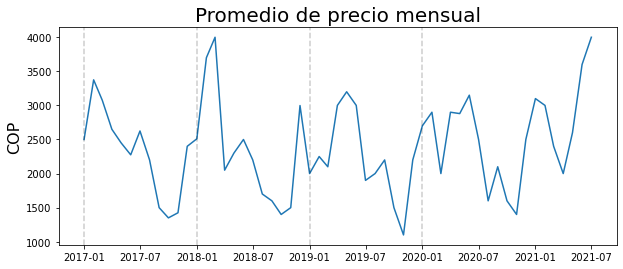

In [4]:
from time import time
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

start_date = datetime(2017,1,1)
end_date = datetime(2021,7,1)

plt.figure(figsize=(10,4))
plt.plot(df)
plt.title('Promedio de precio mensual', fontsize=20)
plt.ylabel('COP', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)


In [5]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = "AIC")
    print("1. ADF. : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num of Lags : ", dftest[2])
    print("4. Num de observaciones usadas por ADF calculo de regression y valores criticos : ",dftest[3])
    print("5. Valores criticos : ")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

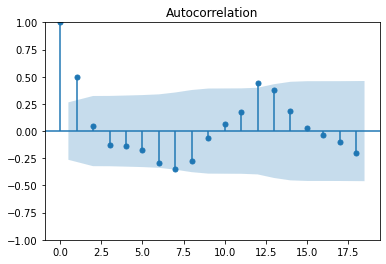

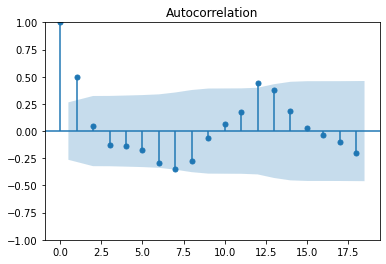

In [6]:
plot_acf(df)

In [7]:
ad_test(df['precio'])


# Ho: La serie es no-estacionaria
# Ha: La serie es estacionaria


# Obtenemos un P-Valor >  alpha(5%) -> No rechazo Ho
# La serie es no-estacionaria

1. ADF. :  -1.6475714467979532
2. P-Value :  0.4583072930988952
3. Num of Lags :  11
4. Num de observaciones usadas por ADF calculo de regression y valores criticos :  43
5. Valores criticos : 
	 1% :  -3.5925042342183704
	 5% :  -2.931549768951162
	 10% :  -2.60406594375338


In [8]:
# Diferenciamos la serie

df_diff = df.diff(periods=1)
df_diff = df_diff[1:]
print(df_diff.shape)
df_diff.head()


(54, 1)


precio
Fecha             
2017-02-01   875.0
2017-03-01  -300.0
2017-04-01  -425.0
2017-05-01  -200.0
2017-06-01  -175.0

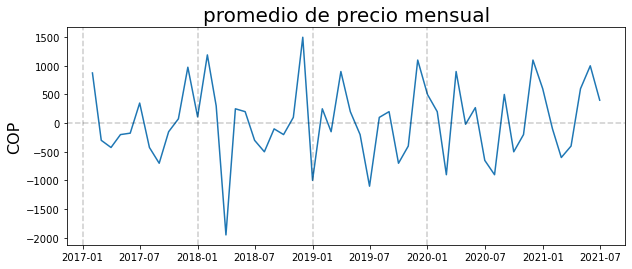

In [9]:
plt.figure(figsize=(10,4))
plt.plot(df_diff)
plt.title('promedio de precio mensual', fontsize=20)
plt.ylabel('COP', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)


<BarContainer object of 15 artists>

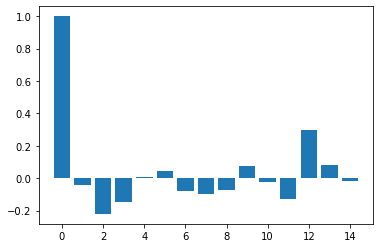

In [10]:
# Autocorrelation function ACF

from statsmodels.tsa.stattools import acf, pacf

acf_vals = acf(df_diff)
num_lags = 15
plt.bar(range(num_lags), acf_vals[:num_lags])

# Basados en ACF, nos debemos basar en un SARIMA(0,0,1)(12)

<BarContainer object of 15 artists>

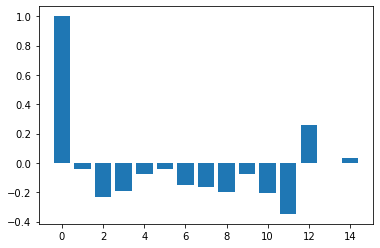

In [11]:
# Partial Autocorrelation function PACF

pacf_vals = pacf(df_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

# Basados en PACF, nos debemos basar en un SARIMA(1,0,0)(12)

In [12]:
ad_test(df_diff['precio'])

1. ADF. :  -5.874017941984635
2. P-Value :  3.190769893029763e-07
3. Num of Lags :  10
4. Num de observaciones usadas por ADF calculo de regression y valores criticos :  43
5. Valores criticos : 
	 1% :  -3.5925042342183704
	 5% :  -2.931549768951162
	 10% :  -2.60406594375338


In [13]:
# TEST VS. TRAIN

print("Base de datos normal", df.shape)
train=df.iloc[:-15]
test=df.iloc[-15:]
print("Datos entrenamiento" , train.shape)
print("Datos testeo", test.shape)

Base de datos normal (55, 1)
Datos entrenamiento (40, 1)
Datos testeo (15, 1)


In [14]:
# Defino el modelo

my_order = (0,1,0)
my_seasonal_order = (1,0,1,12)

modelo = SARIMAX(train, order=my_order,seasonal_order=my_seasonal_order)


In [15]:
# entrenamiento de modelo SARIMA
start=time()
model_fit=modelo.fit()
end=time()
print('Model Fitting Time: ', end - start)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03672D+01    |proj g|=  1.98689D+00

At iterate    5    f=  9.26294D+00    |proj g|=  1.92945D-01

At iterate   10    f=  8.96715D+00    |proj g|=  2.39128D-02

At iterate   15    f=  7.70698D+00    |proj g|=  1.94499D-02

At iterate   20    f=  7.67929D+00    |proj g|=  6.04685D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     32      1     0     0   2.153D-07   7.679D+00
  F =   7.6792902145628315     

CONVERG

 This problem is unconstrained.


In [16]:
# Resumen del modelo

print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               precio   No. Observations:                   40
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -307.172
Date:                              Tue, 16 Nov 2021   AIC                            620.343
Time:                                      19:57:59   BIC                            625.334
Sample:                                  01-01-2017   HQIC                           622.134
                                       - 04-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4562      0.177     -2.571      0.010      -0.804      -0.108
ma.S.L12       1.00

In [17]:
# Predicciones modelo AR

predictions = model_fit.forecast(len(test))
predictions = pd.Series(predictions, index=test.index)
residuals = test - predictions

Text(0, 0.5, 'Error')

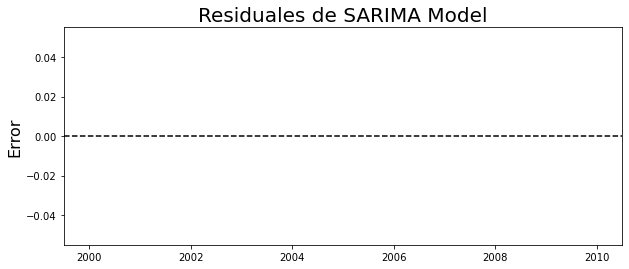

In [18]:
# Residuales PLOT

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuales de SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

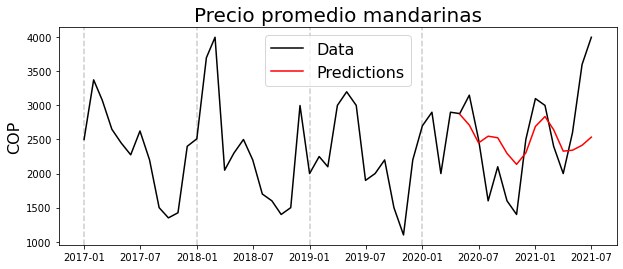

In [19]:
plt.figure(figsize=(10,4))

plt.plot(df, color="black")
plt.plot(predictions,color="red")

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Precio promedio mandarinas', fontsize=20)
plt.ylabel('COP', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)


In [49]:
rmse1 = sqrt(mean_squared_error(predictions,test))
print(rmse1)

649.0102956129232


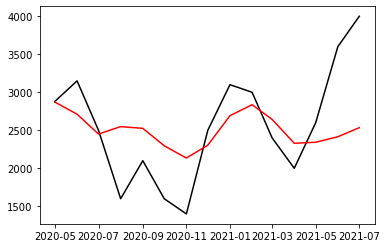

In [40]:
plt.plot(test, color="black")
plt.plot(predictions, color="Red")

In [41]:
# Ahora comprobemos que nos dice la m치quina

stepwise_fit = auto_arima(df,
                         trace=True,   # este componente hace que nos vaya mostrando mientras va procesando e modelo
                         supress_warnings=True)

stepwise_fit.summary()

# Nos dice que el mejor modelo es ARMA(0,2)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=865.184, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=878.295, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=863.053, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=862.113, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1018.283, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=862.442, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=861.558, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=863.680, Time=0.01 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=863.749, Time=0.01 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=865.556, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=932.147, Time=0.05 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 0.262 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   55
Model:               SARIMAX(0, 0, 2)   Log Likelihood                -426.779
Date:                Tue, 16 Nov 2021   AIC                            861.558
Time:                        19:59:50   BIC                            869.587
Sample:                             0   HQIC                           864.663
                                 - 55                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2407.5608    153.507     15.684      0.000    2106.693    2708.428
ma.L1          0.6714      0.132      5.100      0.000       0.413       0.929
ma.L2          0.2418      0.131      1.841      0.066      -0.016       0.499
sigma2       3.19e+05   7.93e+04      4.021      0.000    1.63e+05    4.74e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.97   Prob(JB):                         0.51
Heteroskedasticity (H):               0.94   Skew:                             0.08
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

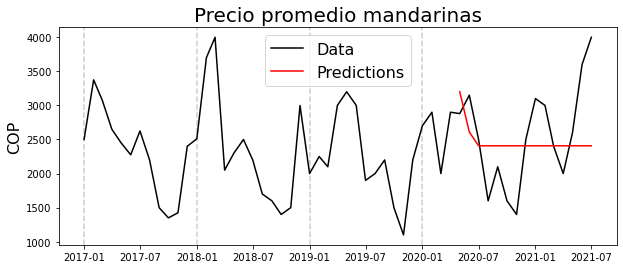

In [42]:
# Predicciones modelo AR

predictions1 = stepwise_fit.predict(len(test))
predictions1 = pd.Series(predictions1, index=test.index)
residuals1 = test - predictions1

plt.figure(figsize=(10,4))

plt.plot(df, color="black")
plt.plot(predictions1,color="red")

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Precio promedio mandarinas', fontsize=20)
plt.ylabel('COP', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)



In [50]:
rmse2 = sqrt(mean_squared_error(predictions1,test))
print(rmse1)

649.0102956129232


In [51]:
# RESULTADOS

print("resultados modelo 1 : " ,rmse1)
print("resultados modelo 2 : " ,rmse2)

resultados modelo 1 :  649.0102956129232
resultados modelo 2 :  721.9558477512701
